In [9]:
import pandas as pd
import numpy as np
from gurobipy import *
from scipy import sparse
from itertools import combinations
import time
import matplotlib.pyplot as plt

In [10]:
# leer datos de minelib
# obtener funcion objetivo del .pcpsp, para comparar
# el resultado del modelo gurobi con el modelo AMPL
data_name = 'newman1'
pcpsp_path = '../minelib_inputs/' + data_name + '.pcpsp'
prec_path = '../minelib_inputs/' + data_name + '.prec'
upit_path = '../minelib_inputs/'+ data_name + '.upit'
objective_function_pcpsp = {}
resource_constraint_ub_limits = {}
resource_constraint_lb_limits = {}
resource_constraint_coefficients = {}
with open(pcpsp_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        if linea_lista[0] == 'NAME:':
            dato = linea_lista[1].strip('\n')
            name = dato
        elif linea_lista[0] == 'NBLOCKS:':
            dato = linea_lista[1].strip('\n')
            nblocks = int(dato)
        elif linea_lista[0] == 'NPERIODS:':
            dato = linea_lista[1].strip('\n')
            nperiods = int(dato)
        elif linea_lista[0] == 'NDESTINATIONS:':
            dato = linea_lista[1].strip('\n')
            ndestinations = int(dato)
        elif linea_lista[0] == 'NRESOURCE_SIDE_CONSTRAINTS:':
            dato = linea_lista[1].strip('\n')
            nresource_side_constraints = int(dato)
        elif linea_lista[0] == 'NGENERAL_SIDE_CONSTRAINTS:':
            dato = linea_lista[1].strip('\n')
            ngeneral_side_constraints = int(dato)
        elif linea_lista[0] == 'DISCOUNT_RATE:':
            dato = linea_lista[1].strip('\n')
            discount_rate = float(dato)
        elif linea_lista[0] == 'RESOURCE_CONSTRAINT_LIMITS:':
            for r in range(nresource_side_constraints):
                for t in range(nperiods):
                    linea = f.readline()
                    lista = linea.split()
                    if lista[2] == 'L':
                        resource_constraint_ub_limits[r,t] = int(lista[-1])
                        resource_constraint_lb_limits[r,t] = '-Infinity' # falta hacer para el caso general
                    else:
                        print('Este problema tiene cotas inferiores.')
                        break
        elif linea_lista[0] == 'OBJECTIVE_FUNCTION:':
            for b in range(nblocks):
                linea = f.readline()
                lista= linea.split()
                for d in range(ndestinations):
                    objective_function_pcpsp[b,d] = float(lista[d+1])
        elif linea_lista[0] == 'RESOURCE_CONSTRAINT_COEFFICIENTS:':
                for linea in f:
                    if linea == 'EOF\n':
                        break
                    lista = linea.split()
                    b = int(lista[0])
                    d = int(lista[1])
                    r = int(lista[2])
                    resource_constraint_coefficients[b,r,d] = float(lista[3])

# llenar con ceros las entradas de resource_constraint_coefficients
# que no está definidas
print("Antes de llenar resource_constraint_coefficients size: %d" % (len(resource_constraint_coefficients)))
for b,r,d in itertools.product(range(nblocks), range(nresource_side_constraints),range(ndestinations)):
    if not (b,r,d) in resource_constraint_coefficients:
        resource_constraint_coefficients[b,r,d] = 0

# block value list para upit
bv_list = list() 
with open(upit_path, 'r') as f:
    for i in range(4):
        f.readline()
    for line in f:
        if not line == 'EOF\n':
            lista = line.split()
            bv_list.append(float(lista[1]))

print('Data base name: %s' % (name))
print('NBLOCKS: %d' % nblocks)
print('NPERIODS: %d' % nperiods)
print('NDESTINATIONS: %d' % ndestinations)
print('NRESOURCE_SIDE_CONSTRAINTS: %d' % nresource_side_constraints)
print('NGENERAL_SIDE_CONSTRAINTS: %d' % ngeneral_side_constraints)
print('DISCOUNT_RATE: %.2f' % discount_rate)

Antes de llenar resource_constraint_coefficients size: 3180
Data base name: Newman1
NBLOCKS: 1060
NPERIODS: 6
NDESTINATIONS: 2
NRESOURCE_SIDE_CONSTRAINTS: 2
NGENERAL_SIDE_CONSTRAINTS: 0
DISCOUNT_RATE: 0.08


In [11]:
len(resource_constraint_coefficients)

4240

In [12]:
len(objective_function_pcpsp)

2120

In [13]:
nblocks*ndestinations*nresource_side_constraints

4240

In [14]:
# resolver upit
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(LinExpr([bv_list[i]for i in range(nblocks)], [x[i] for i in range(nblocks)]), GRB.MAXIMIZE)
# definir restricciones
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()
# recuperar upit
blocks_id_upit = [i for i in range(nblocks) if x[i].x==1] # recuperar upit
print('UPIT BLOCKS: %d' % len(blocks_id_upit))

Optimize a model with 3922 rows, 1060 columns and 7844 nonzeros
Variable types: 0 continuous, 1060 integer (1060 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 989307.55494
Found heuristic solution: objective 2.608690e+07
Presolve removed 3922 rows and 1060 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 2.60869e+07 989308 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.608689902597e+07, best bound 2.608689902597e+07, gap 0.0000%
UPIT BLOCKS: 1059


In [15]:
# funcion para check optimalidad en STEP1
def check_opt_vect(sol, particion, ell, iteracion):
    for h in range(1,ell[iteracion-1]+1):
        arreglo = np.array([sol[iteracion][b].x for b in particion[h,iteracion-1]])
        summ = np.matmul(arreglo,np.ones(arreglo.shape))
        if not (np.isclose(summ,0) or np.isclose(summ,len(particion[h,iteracion-1]))):
            return False
    return True

def cambio_base_sparse(A_prec,base_dicc,iteracion,period):
    new_cols = []
    #A_ret = np.matmul(A_prec,base[iteracion,period][1])
    A_ret = A_prec*base[iteracion,period][1]
    for h,ei in base[iteracion,period].items():
        if h >=2:
            #A_ret = np.column_stack((A_ret,np.matmul(A_prec,ei)))
            A_ret = sparse.hstack((A_ret,A_prec*ei))
    return sparse.csr_matrix(A_ret)

def cambio_base(A_prec, base_dicc, iteracion, period):
    # notar que aqui base tiene que se pasado
    # en array
    new_cols = []
    A_ret = np.matmul(A_prec,base[iteracion,period][1])
    #A_ret = A_prec*base[iteracion,period][1]
    for h,ei in base[iteracion,period].items():
        if h >=2:
            A_ret = np.column_stack((A_ret,np.matmul(A_prec,ei)))
            #A_ret = sparse.hstack((A_ret,A_prec*ei))
    return A_ret

def at_by_key(b,d,t):
    if d == 0 and t > 0:
        return b,ndestinations-1,t-1
    elif d > 0:
        return b,d-1,t
    elif d == 0 and t == 0:
        print('at_by_key no esta difinida para los valores d = %d, t = %d' % (d,t))
        
def actualizar_coeff(modelo,A,cols,name,l):
    lhs = A[:,cols]
    coeffs_matrix = lhs.sum(axis=1)
    for i,coeff in enumerate(coeffs_matrix): # va a recorrer todas las filas de las matrices l veces
        modelo.chgCoeff(constr=modelo.getConstrByName(name+'%d' % i),
                           newvalue=coeff.A[0,0],var=modelo.getVarByName(name='lambda%d'%l))

In [16]:
R = ndestinations
T = nperiods
# coeff. de las side constraints:
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
rhs = {}
# conjuntos de indices
blocks = blocks_id_upit 
blockTimesDest = list(itertools.product(blocks,range(ndestinations)))
resourceTimesPeriod = list(itertools.product(list(range(nresource_side_constraints)),
                                             list(range(nperiods))))
blocks_prime = list(itertools.product(blocks, list(range(ndestinations)),list(range(nperiods))))

# crear un diccionario con los vecinos de cada bloque (precedencia espacial)
vecinos = {}
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in range(nblocks):
            vecinos[a]=set()
            for j in range(nvecinos): # reviasar que ocurre con los que no tienen vecinos!
                b = int(linea_lista[j+2])
                vecinos[a].add(b)
                
# Construir la matriz para las precedencias 3
matrix_lista = []
for block in blocks:
    if vecinos[block]:
        nrows = len(vecinos[block])
        bloque_arr = np.zeros((nrows,nblocks-1))
        bloque_arr = np.insert(bloque_arr,block,np.ones((nrows)),axis=1)
        for row,vecino in enumerate(vecinos[block]):
            bloque_arr[row,vecino] = -1
        matrix_lista.append(sparse.csr_matrix(bloque_arr))

A_sparse = sparse.vstack(matrix_lista, format='csr')
A = A_sparse.toarray()



In [25]:
len(vecinos)

1060

In [17]:
# recalcular coeficientes de la funcion objetivo para PCP_by
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]


c_hat = {}

for b,d,t in blocks_prime:
    if t==0 and d==0:
        c_hat[b,d,t] = -c[b,d,t]
    elif d<=ndestinations-2 and t>=1:
        c_hat[b,d,t] = c[b,d+1,t]
    elif d==ndestinations-1 and t<=nperiods-2:
        c_hat[b,d,t] = c[b,0,t+1]
    else:
        c_hat[b,d,t] = 0
    
cx2 = {}
for b,d,t in blocks_prime:
    if t==0:
        cx2[b,d,t] = -c_hat[b,d,0]
    else:
        cx2[b,d,t] = c[b,d,t]-c_hat[b,d,t]
cx2_array = np.array([cx2[b] for b in blocks_prime])
cx2_sparse = sparse.csr_matrix(cx2_array)

In [18]:
# LHS: a partir de la formula original
rows_1 = []
rows_2 = []
rows_3 = []
fila = 0
cols_1 = []
cols_2 = []
data_1 = []
data_2 = []
data_3 = []
cols_3 = []
cols_4 = []
for t in range(T):
    for r in range(nresource_side_constraints):
        if t>0:
            for b in range(nblocks):
                for d in range(R):
                    if d>0:
                        rows_1.append(fila)
                        cols_1.append(b+d*nblocks+t*R*nblocks)
                        cols_2.append(b+(d-1)*nblocks+t*R*nblocks)
                        data_1.append(q[b,r,d])
                    else:
                        rows_2.append(fila)
                        rows_3.append(fila)
                        cols_3.append(b+0*nblocks+t*R*nblocks)
                        cols_4.append(b+(R-1)*nblocks+(t-1)*R*nblocks)
                        data_2.append(q[b,r,0])
                        data_3.append(-q[b,r,0])
        else:
            for b in range(nblocks):
                for d in range(R):
                    if d>0:
                        rows_1.append(fila)
                        cols_1.append(b+d*nblocks)
                        cols_2.append(b+(d-1)*nblocks)
                        data_1.append(q[b,r,d])
                    else:
                        rows_2.append(fila)
                        cols_3.append(b+0*nblocks)
                        data_2.append(q[b,r,0])
        fila+=1
M1 = sparse.csr_matrix((data_1,(rows_1,cols_1)), shape=(fila,nblocks*R*T))
M2 = sparse.csr_matrix(([-i for i in data_1],(rows_1,cols_2)), shape=(fila,nblocks*R*T))
M3 = sparse.csr_matrix((data_2,(rows_2,cols_3)), shape=(fila,nblocks*R*T))
M4 = sparse.csr_matrix((data_3,(rows_3,cols_4)), shape=(fila,nblocks*R*T))
LHS_sparse = M1+M2+M3+M4

# matriz de precedencia espacial
rows = []
cols_plus = []
cols_minus = []
data = []
row = 0
for t in range(T):
    for b in range(nblocks):
        if vecinos[b]:
            for vecino in vecinos[b]:
                rows.append(row)
                cols_plus.append(b+(R-1)*nblocks+t*R*nblocks)
                cols_minus.append(vecino+(R-1)*nblocks+t*R*nblocks)
                data.append(1)
                row+=1
            
AEplus = sparse.csc_matrix((data,(rows,cols_plus)),shape=(row,nblocks*R*T))
AEminus = sparse.csc_matrix(([-1 for dato in data],(rows,cols_minus)),shape=(row,nblocks*R*T))
AE = AEplus + AEminus

# matriz de precedencia en el destino
rows = []
cols_plus = []
cols_minus = []
data = []
row = 0
for t in range(T):
    for d in range(R-1):
        for b in range(nblocks):
            rows.append(row)
            cols_plus.append(b + d*nblocks + t*R*nblocks)
            cols_minus.append(b + (d+1)*nblocks + t*R*nblocks)
            data.append(1)
            row +=1
            
ADplus = sparse.csr_matrix((data,(rows,cols_plus)),shape=(row,nblocks*R*T))
ADminus = sparse.csr_matrix(([-1 for dato in data],(rows,cols_minus)),shape=(row,nblocks*R*T))
AD = ADplus+ADminus

# matriz de precedencia temporal (ex M)
rows= []
cols_plus = []
data= []
cols_minus = []
row = 0
for t in range(T-1):
    for b in range(nblocks):
        rows.append(row) # revisar, quizas funciona de casualidad!!!
        cols_plus.append(b+(R-1)*nblocks+t*R*nblocks)
        data.append(1)
        cols_minus.append(b+(t+1)*R*nblocks)        
        row+=1

AT_plus =  sparse.csr_matrix((data,(rows,cols_plus)),shape=(row,nblocks*R*T))
AT_minus =  sparse.csr_matrix(([-1 for data in data],(rows,cols_minus)),shape=(row,nblocks*R*T))
AT = AT_plus+AT_minus

In [20]:
AE.shape

(23532, 12720)

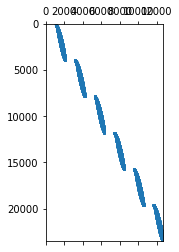

In [23]:
plt.spy(AE,markersize=1)

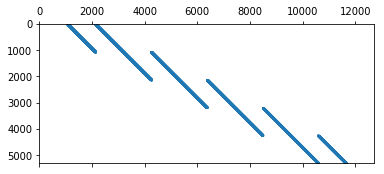

In [15]:
plt.spy(AT, markersize=1)

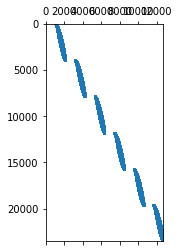

In [17]:
plt.spy(AE, markersize=1.5)

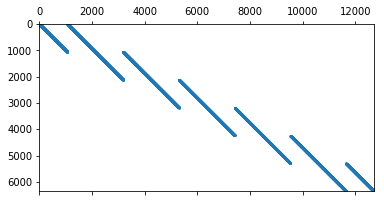

In [18]:
plt.spy(AD, markersize=1)

In [24]:
AD.shape

(6360, 12720)

In [39]:
# BZ usando LHS_sparse para actualizar la fn objetivo

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
#mu[0] = {}
#for r,t in resourceTimesPeriod:
#    mu[0][r,t] = 0
mu[0] = sparse.dok_matrix((1,nresource_side_constraints*T))
for r in range(nresource_side_constraints):
    for t in range(T):
        mu[0][0,r+nresource_side_constraints*t] = 0

C[1,0] = set(blocks_prime)
time_cm = []
time_obj_aux_sp = []
#problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
problema_aux.Params.presolve = 0
time_prec3_vec = []
while True:
    if k==10:
        break
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    mu_lhs = mu[k-1]*LHS_sparse
    fn_objetivo = cx-LinExpr([mu_lhs[0,b+nblocks*d+t*R*nblocks] for b,d,t in blocks_prime],
                             [x[b] for b in blocks_prime])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    time_obj_aux_sp.append(time.time()-init_obj_aux)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
            
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    init_base = time.time()
    for t in range(nperiods):
        base[k,t] = {}
        for h in range(1,1+eles[k]):
            base[k,t][h] = sparse.csr_matrix(np.array([((b,ndestinations-1,t) in C[h,k]) for b in range(nblocks)]).reshape((nblocks,1)))
    
    print('Construir base toma: %.2f[s]' % (time.time()-init_base))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
     
    time_prec3_vec.append(time.time()-init_prec_3)
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: sin at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    #mu[k] = {}
    #for r in range(nresource_side_constraints):
    #    for t in range(nperiods):
    #        mu[k][r,t] = side_const[r,t].pi
    mu[k] = sparse.dok_matrix((1,nresource_side_constraints*T))
    for r in range(nresource_side_constraints):
        for t in range(T):
            mu[k][0,r+nresource_side_constraints*t] = side_const[r,t].pi
    
    mu[k] = sparse.csr_matrix(mu[k])
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    #if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-05) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
    #    # recuperar z[k] la solucion del optimo
    #    print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
    #    print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
    #    break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.40

Resolviendo problema auxiliar: k = 1
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.09 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2312 iterations and 0.09 seconds
Optimal objective  2.613669784e+07
Resolver problema auxiliar tomo: 0.10[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 0.05

Construccion del modelo P2^k
Construir base toma: 0.00[s]
Proyectar variable en H^kx = 0 tomo: 0.06[s]
Calcular fn

Construir base toma: 0.06[s]
Proyectar variable en H^kx = 0 tomo: 0.13[s]
Calcular fn obj y actualizarla: 0.40[s]
Agregar precedencias 1 : 0.11[s]
Agregar precedencias 2: 0.16[s]
Agregar precedencias 3: 0.58[s]
Construir LinExpr para side const.: 0.33[s]
Agrergar side const.: 0.27[s]
Agregar restricciones: 1.44[s]

Construccion del modelo P2^k tomo:2.04[s]

Resolviendo master problem: k=6
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:0.02[s]
Valor del problema maestro en iter k=6: 23967094.48

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[5] = mu[6]
Verificar mu[5] = mu[6] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.37

Resolviendo problema auxiliar: k = 7
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 5e+06]
  Bounds range     [1e+00

In [10]:
# BZ vetorizado con csr matrices (solo las precedencias espaciales)

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
time_obj_aux = []
problema_aux.setParam( 'OutputFlag', True) # El modelo no imprime output en pantalla
problema_aux.Params.presolve = 0
time_prec3_vec = []
while True:
    #if k==10:
    #    break
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    #fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    time_obj_aux.append(time.time()-init_obj_aux)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    # modificamos la particion, para modificar las restricciones de precedencia temporal de una
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    init_base = time.time()
    for t in range(nperiods):
        base[k,t] = {}
        for h in range(1,1+eles[k]):
            base[k,t][h] = sparse.csr_matrix(np.array([((b,ndestinations-1,t) in C[h,k]) for b in range(nblocks)]).reshape((nblocks,1)))
    
    print('Construir base toma: %.2f[s]' % (time.time()-init_base))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    #cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
    #            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
    #            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    cx_lmbda = quicksum([cx2[b]*x_lmbda[b] for b in blocks_prime])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    init_prec_3 = time.time()
    for t in range(nperiods):
        init_cb = time.time()
        A_tilde = cambio_base_sparse(A_sparse,base,k,t)
        for row in range(A_tilde.shape[0]):
            start = A_tilde.indptr[row]
            end = A_tilde.indptr[row+1]
            variables = [lmbda[j+1] for j in A_tilde.indices[start:end]]
            coeff  = A_tilde.data[start:end]
            expr = LinExpr(coeff,variables)
            model_p2k.addConstr(expr <=0)

    time_prec3_vec.append(time.time()-init_prec_3)
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: sin at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', True )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}#sparse.dok_matrix((1,nresource_side_constraints*T))
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
            #mu[k][0,r+nresource_side_constraints*t] = side_const[r,t].pi
    
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-05) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.25

Resolviendo problema auxiliar: k = 1
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.09 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2312 iterations and 0.10 seconds
Optimal objective  2.613669784e+07
Resolver problema auxiliar tomo: 0.13[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 0.05

Construccion del modelo P2^k
Construir base

Coefficient statistics:
  Matrix range     [1e+00, 6e+06]
  Objective range  [6e+03, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 2e+06]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5871728e+07   7.745369e+03   0.000000e+00      0s
       5    2.3677767e+07   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds
Optimal objective  2.367776696e+07
Resolver P2^k tomo:0.05[s]
Valor del problema maestro en iter k=4: 23677766.96

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[3] = mu[4]
Verificar mu[3] = mu[4] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.16

Resolviendo problema auxiliar: k = 5
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Iter

   Prev: -1  Min: -1  Max: 2  Default: -1
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 35193 rows, 31 columns and 10907 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 6e+06]
  Objective range  [1e+02, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 2e+06]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6136698e+07   5.632725e+02   0.000000e+00      0s
      28    2.4005223e+07   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.03 seconds
Optimal objective  2.400522287e+07
Resolver P2^k tomo:0.05[s]
Valor del problema maestro en iter k=8: 24005222.87

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[7] = mu[8]
Verificar mu[7] = mu[8] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.22

Resolviendo problema auxiliar: k = 9
Optimize a model with 35181 rows, 12708 columns and 7

Agregar precedencias 1 : 0.33[s]
Agregar precedencias 2: 0.29[s]
Agregar precedencias 3: 0.39[s]
Construir LinExpr para side const.: 0.52[s]
Agrergar side const.: 0.67[s]
Agregar restricciones: 2.22[s]

Construccion del modelo P2^k tomo:3.10[s]

Resolviendo master problem: k=12
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 35193 rows, 41 columns and 11187 nonzeros
Coefficient statistics:
  Matrix range     [5e-13, 6e+06]
  Objective range  [1e+02, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 2e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6136698e+07   5.632725e+02   0.000000e+00      0s
      41    2.4007197e+07   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.03 seconds
O

In [10]:
# BZ contruyendo maestro una sola vez y actualizando en cada iteracion

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])

# Construccion del problema maestro
model_p2k = Model()
lmbda = {}
lmbda[1] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % 1)
    
# precedencia temporal
for i,coeff in enumerate(AT.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precTemp%d' % i)
    
# precedencia destinos
for i,coeff in enumerate(AD.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precDest%d' % i)
    
# precedencia espacial
for i,coeff in enumerate(AE.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precEsp%d' % i)

model_p2k.update()
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
time_obj_aux = []
#problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
problema_aux.Params.presolve = 0
time_prec3_vec = []
while True:
    #if k ==10:
    #    break
    # STEP 1: resolver L(PCPby,mu[k-1])
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    #fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    time_obj_aux.append(time.time()-init_obj_aux)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    print('Valor del problema auxiliar en iter k=%d: %.2f' % (k,problema_aux.ObjVal))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion y actualizar coefficientes')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    # modificamos la particion, para modificar las restricciones de precedencia temporal de una
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                model_p2k.update()
            
            cols = [b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]
            actualizar_coeff(model_ p2k,AT,cols,'precTemp',count)
            actualizar_coeff(model_p2k,AD,cols,'precDest',count)
            actualizar_coeff(model_p2k,AE,cols,'precEsp',count)
            
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                model_p2k.update()
                
            cols = [b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]
            actualizar_coeff(model_p2k,AT,cols,'precTemp',count)
            actualizar_coeff(model_p2k,AD,cols,'precDest',count)
            actualizar_coeff(model_p2k,AE,cols,'precEsp',count)
    
    print('Determinar particion y actualizar para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    model_p2k.update()
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    #if k>=2:
        #for t in range(T-1):
        #    for b in blocks:
        #        model_p2k.remove(prec_temp[b,t])
                
        #for b in blocks:
        #    for t in range(T):
        #        for d in range(R-1):
        #            model_p2k.remove(prec_dest[b,d,t])
    
    # precedencia temporal
    #prec_temp = {}
    #for t in range(nperiods-1):
    #    for b in blocks:
    #        prec_temp[b,t] = model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])

    # precedencia en los destinos
    #prec_dest = {}
    #for d in range(ndestinations-1):
    #    for t in range(nperiods):
    #        for b in blocks:
    #            prec_dest[b,d,t] = model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    init_obj = time.time()
    #cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
    #            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
    #            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    cx_lmbda = quicksum([cx2[b]*x_lmbda[b] for b in blocks_prime])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregar side constraints: sin at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    if k>=2:
        for t in range(T):
            for r in range(nresource_side_constraints):
                model_p2k.remove(side_const[r,t])
    
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    #print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    #model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}#sparse.dok_matrix((1,nresource_side_constraints*T))
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
            #mu[k][0,r+nresource_side_constraints*t] = side_const[r,t].pi
    
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-05) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.29

Resolviendo problema auxiliar: k = 1
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.09 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2312 iterations and 0.10 seconds
Optimal objective  2.613669784e+07
Resolver problema auxiliar tomo: 0.13[s]
Valor del problema auxiliar en iter k=1: 26136697.84

Chequear optimalidad tomo: 0.00

Encontrar particion y actualizar coefficientes
Determinar particion y actualizar para k = 1 tomo: 1.26

Construccion del mode

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1263363e+37   2.650000e+33   1.126336e+07      0s
    3686    2.1178460e+07   0.000000e+00   0.000000e+00      0s

Solved in 3686 iterations and 0.22 seconds
Optimal objective  2.117845976e+07
Resolver problema auxiliar tomo: 0.25[s]
Valor del problema auxiliar en iter k=5: 21178459.76

Chequear optimalidad tomo: 0.03

Encontrar particion y actualizar coefficientes
Determinar particion y actualizar para k = 5 tomo: 5.29

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.24[s]
Calcular fn obj y actualizarla: 0.21[s]
Construir LinExpr para side const.: 0.38[s]
Agrergar side const.: 0.34[s]

Construccion del modelo P2^k tomo:1.20[s]

Resolviendo master problem: k=5
Parameter presolve unchanged
   Value: 0  Min: -1  Max: 2  Default: -1
Op

Determinar particion y actualizar para k = 9 tomo: 17.31

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.55[s]
Calcular fn obj y actualizarla: 0.63[s]
Construir LinExpr para side const.: 1.24[s]
Agrergar side const.: 1.17[s]

Construccion del modelo P2^k tomo:3.62[s]

Resolviendo master problem: k=9
Parameter presolve unchanged
   Value: 0  Min: -1  Max: 2  Default: -1
Optimize a model with 35204 rows, 35 columns and 11008 nonzeros
Coefficient statistics:
  Matrix range     [2e-13, 6e+06]
  Objective range  [1e+02, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 2e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
       0    2.6136698e+07   5.632725e+02   0.000000e+00      0s
      34    2.4006649e+07   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.03 seconds
Optimal objective  2.400664933e+07
Resolver P2^k tomo:0.05[s]
Valor del problema maestro en iter k=9: 240

   Value: 0  Min: -1  Max: 2  Default: -1
Optimize a model with 35204 rows, 42 columns and 11200 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 6e+06]
  Objective range  [1e+02, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 2e+06]
       0    2.6136698e+07   5.632725e+02   0.000000e+00      0s
      41    2.4007200e+07   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.03 seconds
Optimal objective  2.400719954e+07
Resolver P2^k tomo:0.07[s]
Valor del problema maestro en iter k=13: 24007199.54

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[12] = mu[13]
Verificar mu[12] = mu[13] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.27

Resolviendo problema auxiliar: k = 14
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 5e+06]
  Bounds range     [1e+

In [14]:
# dicc de matrices
prec_matrix = {'precTemp':AT,'precDest':AD,'precEsp':AE}


In [16]:
# sin llamar funciones
# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])

# Construccion del problema maestro
model_p2k = Model()
lmbda = {}
lmbda[1] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % 1)
    
# precedencia temporal
for i,coeff in enumerate(AT.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precTemp%d' % i)
    
# precedencia destinos
for i,coeff in enumerate(AD.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precDest%d' % i)
    
# precedencia espacial
for i,coeff in enumerate(AE.sum(axis=1)):
    model_p2k.addConstr(coeff.A[0,0]*lmbda[1] <=0, name='precEsp%d' % i)

model_p2k.update()
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
time_obj_aux = []
#problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
problema_aux.Params.presolve = 0
time_prec3_vec = []
names = ['precTemp', 'precDest', 'precEsp']
while True:
    #if k ==10:
    #    break
    # STEP 1: resolver L(PCPby,mu[k-1])
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    #fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    time_obj_aux.append(time.time()-init_obj_aux)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    print('Valor del problema auxiliar en iter k=%d: %.2f' % (k,problema_aux.ObjVal))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion y actualizar coefficientes')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    # modificamos la particion, para modificar las restricciones de precedencia temporal de una
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                model_p2k.update()
            
            cols = [b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]
            for name in names:
                A  = prec_matrix[name]
                init_sum = time.time()
                lhs = A[:,cols]
                print('sumar toma : %.2f para %s' % (time.time()-init_sum,name))
                coeffs_matrix = lhs.sum(axis=1)
                init_chg = time.time()
                for i,coeff in enumerate(coeffs_matrix):
                    model_p2k.chgCoeff(constr=model_p2k.getConstrByName(name+'%d' % i),
                                       newvalue=coeff.A[0,0],var=model_p2k.getVarByName(name='lambda%d'%count))
                
                print('cambiar coeficientes toma: %.2f' % (time.time()-init_chg))
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                model_p2k.update()
                
            cols = [b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]
            for name in names:
                A  = prec_matrix[name]
                init_sum = time.time()
                lhs = A[:,cols]
                coeffs_matrix = lhs.sum(axis=1)
                print('sumar toma : %.2f para %s' % (time.time()-init_sum,name))
                init_chg = time.time()
                for i,coeff in enumerate(coeffs_matrix):
                    model_p2k.chgCoeff(constr=model_p2k.getConstrByName(name+'%d' % i),
                                       newvalue=coeff.A[0,0],var=model_p2k.getVarByName(name='lambda%d'%count))
                
                print('cambiar coeficientes toma: %.2f' % (time.time()-init_chg))
    print('Determinar particion y actualizar para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    model_p2k.update()
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    #if k>=2:
        #for t in range(T-1):
        #    for b in blocks:
        #        model_p2k.remove(prec_temp[b,t])
                
        #for b in blocks:
        #    for t in range(T):
        #        for d in range(R-1):
        #            model_p2k.remove(prec_dest[b,d,t])
    
    # precedencia temporal
    #prec_temp = {}
    #for t in range(nperiods-1):
    #    for b in blocks:
    #        prec_temp[b,t] = model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])

    # precedencia en los destinos
    #prec_dest = {}
    #for d in range(ndestinations-1):
    #    for t in range(nperiods):
    #        for b in blocks:
    #            prec_dest[b,d,t] = model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    init_obj = time.time()
    #cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
    #            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
    #            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    cx_lmbda = quicksum([cx2[b]*x_lmbda[b] for b in blocks_prime])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregar side constraints: sin at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    if k>=2:
        for t in range(T):
            for r in range(nresource_side_constraints):
                model_p2k.remove(side_const[r,t])
    
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    #print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    #model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}#sparse.dok_matrix((1,nresource_side_constraints*T))
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
            #mu[k][0,r+nresource_side_constraints*t] = side_const[r,t].pi
    
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-05) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.19

Resolviendo problema auxiliar: k = 1
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 2312 iterations and 0.08 seconds
Optimal objective  2.613669784e+07
Resolver problema auxiliar tomo: 0.09[s]
Valor del problema auxiliar en iter k=1: 26136697.84

Chequear optimalidad tomo: 0.00

Encontrar particion y actualizar coefficientes
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0

Actualizar fn. obj. tomo: 0.17

Resolviendo problema auxiliar: k = 4
Optimize a model with 35181 rows, 12708 columns and 70362 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0498890e+37   2.543900e+34   2.049889e+07      0s
    1480    2.0708622e+07   0.000000e+00   0.000000e+00      0s

Solved in 1480 iterations and 0.08 seconds
Optimal objective  2.070862152e+07
Resolver problema auxiliar tomo: 0.08[s]
Valor del problema auxiliar en iter k=4: 20708621.52

Chequear optimalidad tomo: 0.02

Encontrar particion y actualizar coefficientes
sumar toma : 0.02 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sum

sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.06
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coefi

cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.13
sumar toma : 

sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.12
sumar toma : 0.02 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precEsp
cambiar coeficientes toma: 0.13
Determinar particion y actualizar para k = 8 

sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.04
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.13
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.12
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.02 para precTemp
cambiar coefi

cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.19
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precEsp
cambiar coeficientes toma: 0.12
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.12
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 

sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.15
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.02 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coefi

sumar toma : 0.02 para precTemp
cambiar coeficientes toma: 0.04
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coefi

cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.16
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.17
sumar toma : 0.00 para precTemp
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precDest
cambiar coeficientes toma: 0.05
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.13
sumar toma : 0.02 para precTemp
cambiar coeficientes toma: 0.02
sumar toma : 0.02 para precDest
cambiar coeficientes toma: 0.03
sumar toma : 0.00 para precEsp
cambiar coeficientes toma: 0.14
sumar toma : 


Solved in 0 iterations and 0.02 seconds
Optimal objective  2.106466776e+07
Resolver problema auxiliar tomo: 0.03[s]
Valor del problema auxiliar en iter k=14: 21064667.76
Algoritmo termino: H^13 w[14] = 0
Valor optimo de BZ: 24007199.54


In [26]:
Valor del problema maestro en iter k=9: 24006649.33

{0: 1, 1: 2, 2: 3, 3: 4}

In [22]:
lmbda[count]

<gurobi.Var *Awaiting Model Update*>

In [21]:
for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                
            lhs = AE[:,[b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]]
            coeffs_matrix = lhs.sum(axis=1)
            for i,coeff in enumerate(coeffs_matrix):
                model_p2k.chgCoeff(constr=model_p2k.getConstrByName('fila%d' % i),
                                   newvalue=coeff.A[0,0],var=model_p2k.getVarByName(name='lambda%d'%count))
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
            if count > eles[k-1]:
                lmbda[count] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % count)
                
            lhs = AE[:,[b+d*nblocks+t*R*nblocks for b,d,t in C[count,k]]]
            coeffs_matrix = lhs.sum(axis=1)
            for i,coeff in enumerate(coeffs_matrix):
                model_p2k.chgCoeff(constr=model_p2k.getConstrByName('fila%d' % i),
                                   newvalue=coeff.A[0,0],var=model_p2k.getVarByName(name='lambda%d'%count))

AttributeError: 'NoneType' object has no attribute '__colno__'

In [ ]:
Valor del problema maestro en iter k=1: 9968150.87

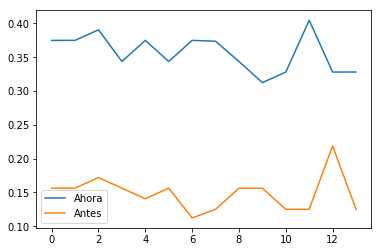

In [16]:
plt.plot(np.arange(k),time_obj_aux_sp, label = 'Ahora')
plt.plot(np.arange(k),time_obj_aux, label = 'Antes')
plt.legend()
plt.show()

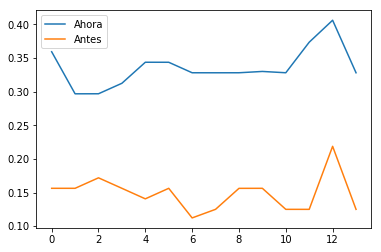

In [19]:
# mismo grafico anterior, pero creando mu sparse mas rapido(?)
plt.plot(np.arange(k),time_obj_aux_sp, label = 'Ahora')
plt.plot(np.arange(k),time_obj_aux, label = 'Antes')
plt.legend()
plt.show()

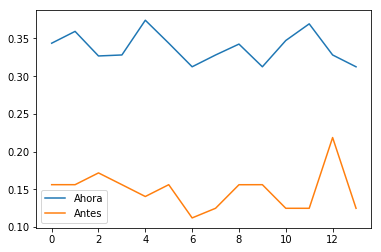

In [27]:
# mismo grafico anterior, pero creando mu sparse.dok en side_const
plt.plot(np.arange(k),time_obj_aux_sp, label = 'Ahora')
plt.plot(np.arange(k),time_obj_aux, label = 'Antes')
plt.legend()
plt.show()

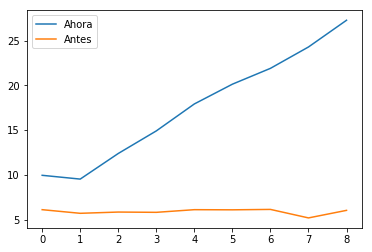

In [41]:
# mismo grafico anterior, pero creando mu sparse.csr_matrix en side_const
plt.plot(np.arange(9),time_obj_aux_sp[:9], label = 'Ahora')
plt.plot(np.arange(9),time_obj_aux[:9], label = 'Antes')
plt.legend()
plt.show()

In [53]:
for i in range(eles[2],eles[1]+eles[2]-1):
    print(i)

3


In [55]:
eles[2]

3

In [38]:
# BZ sin vecotrizar

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
time_prec_3 = []
while True:
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    for t in range(nperiods):
        base[k,t] = {}
        for h in range(1,1+eles[k]):
            base[k,t][h] = sparse.csr_matrix(np.array([((b,ndestinations-1,t) in C[h,k]) for b in range(nblocks)]).reshape((nblocks,1)))
    
    
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    
    init_prec_3 = time.time()
    for a in blocks:
        for b in vecinos[a]:
            for t in range(nperiods):
                model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    time_prec_3.append(time.time()-init_prec_3)
    #for t in range(nperiods):
    #    A_tilde = cambio_base(A,base,k,t)
    #    for row in range(A_tilde.shape[0]):
    #        start = A_tilde.indptr[row]
    #        end = A_tilde.indptr[row+1]
    #        variables = [lmbda[j+1] for j in A_tilde.indices[start:end]]
    #        coeff  = A_tilde.data[start:end]
    #        expr = LinExpr(coeff,variables)
    #        model_p2k.addConstr(expr <=0)
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-04) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.13

Resolviendo problema auxiliar: k = 1
Resolver problema auxiliar tomo: 0.05[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 0.03

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.11[s]
Calcular fn obj y actualizarla: 0.09[s]
Agregar precedencias 1 : 0.06[s]
Agregar precedencias 2: 0.06[s]
Agregar precedencias 3: 0.33[s]
Construir LinExpr para side const.: 0.11[s]
Agrergar side const.: 0.03[s]
Agregar restricciones: 0.62[s]

Construccion del modelo P2^k tomo:0.84[s]

Resolviendo master problem: k=1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:0.03[s]
Valor del problema maestro en iter k=1: 9968150.87

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[0] = mu[1]
Verificar mu[0] = mu[1] tomo: 0.00

Construccion de la funcion obj. para problema

   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:0.03[s]
Valor del problema maestro en iter k=9: 24006649.33

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[8] = mu[9]
Verificar mu[8] = mu[9] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.14

Resolviendo problema auxiliar: k = 10
Resolver problema auxiliar tomo: 0.03[s]

Chequear optimalidad tomo: 0.02

Encontrar particion
Determinar particion para k = 10 tomo: 0.06

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.33[s]
Calcular fn obj y actualizarla: 0.73[s]
Agregar precedencias 1 : 0.19[s]
Agregar precedencias 2: 0.27[s]
Agregar precedencias 3: 0.98[s]
Construir LinExpr para side const.: 0.53[s]
Agrergar side const.: 0.70[s]
Agregar restricciones: 2.69[s]

Construccion del modelo P2^k tomo:3.89[s]

Resolviendo master problem: k=10
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


In [29]:
# BZ vecotrizado con numpy matrices

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx_direct = quicksum([c[b,d,t]*(x[b,d,t]-x[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
            +quicksum([c[b,0,t]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
            +quicksum([c[b,0,0]*x[b,0,0] for b in blocks])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
time_prec3_np = []
while True:
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    fn_objetivo = cx_direct - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    problema_aux.Params.presolve = 0
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    for t in range(nperiods):
        base[k,t] = {}
        for h in range(1,1+eles[k]):
            base[k,t][h] = np.array([((b,ndestinations-1,t) in C[h,k]) for b in range(nblocks)]).reshape((nblocks,1))
    
    
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
                +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
                +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    #cx_lmbda = LinExpr([c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    
    init_prec_3 = time.time()
    #for a in blocks:
    #    for b in vecinos[a]:
    #        for t in range(nperiods):
    #            model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    
    for t in range(nperiods):
        A_tilde = cambio_base(A,base,k,t)
        for row in range(A_tilde.shape[0]):
            expr = LinExpr(A_tilde[row,:],[lmbda[j] for j in range(1,1+eles[k])])
            model_p2k.addConstr(expr <=0)
    time_prec3_np.append(time.time()-init_prec_3)
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: si at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-04) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1


Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.14

Resolviendo problema auxiliar: k = 1
Resolver problema auxiliar tomo: 0.05[s]

Chequear optimalidad tomo: 0.00

Encontrar particion
Determinar particion para k = 1 tomo: 0.05

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.12[s]
Calcular fn obj y actualizarla: 0.09[s]
Agregar precedencias 1 : 0.08[s]
Agregar precedencias 2: 0.09[s]
Agregar precedencias 3: 0.62[s]
Construir LinExpr para side const.: 0.17[s]
Agrergar side const.: 0.03[s]
Agregar restricciones: 1.03[s]

Construccion del modelo P2^k tomo:1.26[s]

Resolviendo master problem: k=1
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:0.03[s]
Valor del problema maestro en iter k=1: 9968150.87

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[0] = mu[1]
Verificar mu[0] = mu[1] tomo: 0.00

Construccion de la funcion obj. para problema

   Prev: -1  Min: -1  Max: 2  Default: -1
Resolver P2^k tomo:0.03[s]
Valor del problema maestro en iter k=9: 24006649.33

Recuperando variables duales
Recuperar variables duales tomo: 0.00

Verificar optimalidad: mu[8] = mu[9]
Verificar mu[8] = mu[9] tomo: 0.00

Construccion de la funcion obj. para problema aux.
Actualizar fn. obj. tomo: 0.17

Resolviendo problema auxiliar: k = 10
Resolver problema auxiliar tomo: 0.05[s]

Chequear optimalidad tomo: 0.02

Encontrar particion
Determinar particion para k = 10 tomo: 0.08

Construccion del modelo P2^k
Proyectar variable en H^kx = 0 tomo: 0.26[s]
Calcular fn obj y actualizarla: 0.81[s]
Agregar precedencias 1 : 0.19[s]
Agregar precedencias 2: 0.22[s]
Agregar precedencias 3: 1.50[s]
Construir LinExpr para side const.: 0.67[s]
Agrergar side const.: 0.73[s]
Agregar restricciones: 3.34[s]

Construccion del modelo P2^k tomo:4.51[s]

Resolviendo master problem: k=10
Changed value of parameter presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


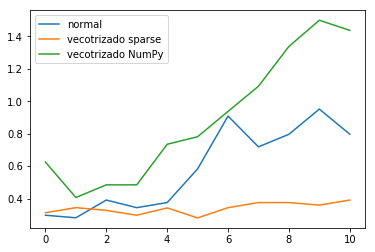

In [30]:
plt.plot(np.arange(len(time_prec_3)),time_prec_3, label = 'normal')
plt.plot(np.arange(len(time_prec_3)),time_prec3_vec, label = 'vecotrizado sparse')
plt.plot(np.arange(len(time_prec_3)),time_prec3_np, label = 'vecotrizado NumPy')
plt.legend()
plt.show()


In [ ]:
# vectorizacion del modeloP2^k
model_toy = Model()
lmbda = {}
for i in range(1,eles[k]+1):
    lmbda[i] = model_toy.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)

model_toy.update()


In [27]:
# crear un array sparse
diag = np.diag(np.ones(nblocks))
for a in blocks:
    for b in vecinos[a]:
        diag[a,b] = -1
A = sparse.csr_matrix(diag)
v = sparse.csr_matrix(np.eye(nblocks))

In [28]:
A*v.toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1., -1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [24]:
np.eye(nblocks)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [60]:
for key,value in C.items():
    print(key)

(1, 0)


In [55]:
eles[2]

3

In [41]:
base = {}
t = 0
C = {}
C[1,0] = blocks_prime
base[1] = np.array([((b,ndestinations-1,t) in C[1,0]) for b in range(nblocks)]).reshape((nblocks,1))
base[1] = sparse.csc_matrix(base[1])

In [33]:
base[1] = sparse.csc_matrix(base[1])

In [34]:
A*base[1].toarray()

array([[ 1.],
       [-1.],
       [-1.],
       ...,
       [ 1.],
       [ 1.],
       [-1.]])

In [36]:
base_arr = {}
A_arr = diag
base_arr[1] = np.array([((b,ndestinations-1,t) in C[1,0]) for b in range(nblocks)]).reshape((nblocks,1))

In [37]:
A_arr*base_arr[1]

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1., -1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [42]:
G = sparse.csr_matrix(np.array([[0,2],[5,0]]))


array([[0, 2],
       [5, 0]], dtype=int32)

In [70]:
# BZ vetorizado con csr matrices (en vez de uasr lambda agregar restricciones)

# calculamos la forma equivalente del problema
# PCP_at, llamada PCP_by.
# funcion objetivo
c = {}
for (b,d,t) in blocks_prime:
    c[b,d,t] = (1.0/(1.0 + discount_rate))**t * objective_function_pcpsp[b,d]

# modelo L(PCP_by,mu[k-1])
problema_aux = Model()
# definir variable de PCP_by
x = {}
for (b,d,t) in blocks_prime:
    x[b,d,t] = problema_aux.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "x(%d,%d,%d)" % (b,d,t))
problema_aux.update()
# agregar restricciones de
# precedencias.
# precedencia temporal
for t in range(nperiods-1):
    for b in blocks:
        problema_aux.addConstr(x[b,ndestinations-1,t] <= x[b,0,t+1])

# precedencia en los destinos
for d in range(ndestinations-1):
    for t in range(nperiods):
        for b in blocks:
            problema_aux.addConstr(x[b,d,t] <= x[b,d+1,t])

# precedencia espacial
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        a = int(linea_lista[0])
        if a in blocks:
            for j in range(nvecinos):
                b = int(linea_lista[j+2])
                for t in range(nperiods):
                    problema_aux.addConstr(x[a,ndestinations-1,t] <= x[b,ndestinations-1,t])

# Funcion objetivo de L(PCP_by,mu[k-1])
cx = LinExpr([cx2[b] for b in blocks_prime],[x[b] for b in blocks_prime])
q = resource_constraint_coefficients
d_rhs = resource_constraint_ub_limits
w = {}
z = {}
eles = {}
eles[0] = 1
k = 1
mu = {}
C = {}
base = {}
mu[0] = {}
for r,t in resourceTimesPeriod:
    mu[0][r,t] = 0
C[1,0] = set(blocks_prime)
time_cm = []
time_obj_aux = []
#problema_aux.setParam( 'OutputFlag', False ) # El modelo no imprime output en pantalla
problema_aux.Params.presolve = 0
time_prec3_vec = []
while True:
    if k==10:
        break
    # STEP 1: resolver L(PCPby,mu[k-1])
    suma = {}
    side_const = LinExpr()
    LHS = {}
    print('\nConstruccion de la funcion obj. para problema aux.')
    init_obj_aux = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x[b,d,t]-x[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS[r,t] = sumando_1+quicksum([q[b,r,0]*(x[b,0,t]-x[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS[r,0] = sumando_1+quicksum([q[b,r,0]*x[b,0,0] for b in blocks])
    
    #mu_sparse = np.zeros((1,nresource_side_constraints*T))
    #for r in range(nresource_side_constraints):
    #    for t in range(T):
    #        mu_sparse[0,r+t*nresource_side_constraints] = mu[k-1][r,t]
            
    #mu_sparse = sparse.csr_matrix(mu_sparse)
    #mu_lhs = mu_sparse*lhs
    #fn_objetivo = cx-LinExpr([mu_lhs[0,b[0]+nblocks*b[1]+b[2]*R*nblocks] for b in blocks_prime],[x[b] for b in blocks_prime])
    #fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]-d_rhs[r,t]) for r,t in resourceTimesPeriod])
    fn_objetivo = cx - quicksum([mu[k-1][r,t]*(LHS[r,t]) for r,t in resourceTimesPeriod])
    problema_aux.setObjective(fn_objetivo, GRB.MAXIMIZE)
    time_obj_aux.append(time.time()-init_obj_aux)
    print('Actualizar fn. obj. tomo: %.2f' % (time.time()-init_obj_aux))
    print('\nResolviendo problema auxiliar: k = %d' % k)
    init_solve_aux = time.time()
    problema_aux.optimize()
    print('Resolver problema auxiliar tomo: %.2f[s]' % (time.time()-init_solve_aux))
    w[k] = x
    # verificar optimalidad de z[k-1]
    init_opt = time.time()
    if k>=2 and check_opt_vect(w,C,eles,k):
        print('Algoritmo termino: H^%d w[%d] = 0' % (k-1,k))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('\nChequear optimalidad tomo: %.2f' % (time.time()-init_opt))
    print('\nEncontrar particion')
    init_part = time.time()
    #STEP 3: encontrar particion de blocks_prime 
    I = [ block for block in blocks_prime if w[k][block].x == 1]
    O = [ block for block in blocks_prime if w[k][block].x == 0]
    count = 0
    for h in range(1,eles[k-1]+1):
        if C[h,k-1].intersection(I):
            count += 1
            C[count,k] = C[h,k-1].intersection(I)
        if C[h,k-1].intersection(O):
            count += 1
            C[count,k] = C[h,k-1].intersection(O)
    
    print('Determinar particion para k = %d tomo: %.2f' % (k,time.time()-init_part))
    eles[k] = count
    # STEP 4: resolver P2k
    print('\nConstruccion del modelo P2^k')
    init_set_p2k = time.time()
    
    model_p2k = Model()
    lmbda = {}
    for i in range(1,eles[k]+1):
        lmbda[i] = model_p2k.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name = "lambda%d" % i)
    
    model_p2k.update()
    # construir base
    init_base = time.time()
    for t in range(nperiods):
        base[k,t] = {}
        for h in range(1,1+eles[k]):
            base[k,t][h] = sparse.csr_matrix(np.array([((b,ndestinations-1,t) in C[h,k]) for b in range(nblocks)]).reshape((nblocks,1)))
    
    print('Construir base toma: %.2f[s]' % (time.time()-init_base))
    # fn objetivo del problema auxiliar P2^k
    init_sev = time.time()
    x_lmbda = {}
    for b in blocks_prime:
        #x_lmbda[b] = quicksum([lmbda[h]*(b in C[h,k])for h in range(1,eles[k]+1)])
        x_lmbda[b] = LinExpr([(b in C[h,k]) for h in range(1,eles[k]+1)],[lmbda[h] for h in range(1,eles[k]+1)])
    print('Proyectar variable en H^kx = 0 tomo: %.2f[s]' % (time.time()-init_sev))
    init_obj = time.time()
    #cx_lmbda = quicksum([c[b,d,t]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d,t in blocks_prime if d>0 and t>0])\
    #            +quicksum([c[b,0,t]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for (b,d,t) in blocks_prime if d==0 and t>0])\
    #            +quicksum([c[b,0,0]*x_lmbda[b,0,0] for b in blocks])
    cx_lmbda = LinExpr([c[b] for b in blocks_prime],[x_lmbda[b] for b in blocks_prime if b[1]>0 and b[2]>0])#+LinExpr([-c[b] for b in blocks_prime if b[1]>0 and b[2]>0],[x_lmbda[b[0],b[1]-1,b[2]] for b in blocks_prime if b[1]>0 and b[2]>0])+LinExpr([c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([-c[b[0],0,b[2]] for b in blocks_prime i b[1]==0 and b[2]>0],[x_lmbda[b[0],ndestinations-1,b[2]-1] for b in blocks_prime i b[1]==0 and b[2]>0])+LinExpr([c[b,0,0] for b in blocks],[x_lmbda[b,0,0] for b in blocks])
    obj_scale = 1e0
    model_p2k.setObjective(obj_scale*cx_lmbda, GRB.MAXIMIZE)
    print('Calcular fn obj y actualizarla: %.2f[s]' % (time.time()-init_obj))
    # agregamos las restricciones
    # para P2k con el cambio de variable
    # agregar restricciones de
    # precedencias.
    init_const = time.time()
    init_prec_1 = time.time()
    for t in range(nperiods-1):
        for b in blocks:
            model_p2k.addConstr(x_lmbda[b,ndestinations-1,t] <= x_lmbda[b,0,t+1])
    
    print('Agregar precedencias 1 : %.2f[s]' % (time.time()-init_prec_1))
    init_prec_2 = time.time()
    for d in range(ndestinations-1):
        for t in range(nperiods):
            for b in blocks:
                model_p2k.addConstr(x_lmbda[b,d,t] <= x_lmbda[b,d+1,t])
    
    print('Agregar precedencias 2: %.2f[s]' % (time.time()-init_prec_2))
    
    init_prec_3 = time.time()
    #for a in blocks:
    #    for b in vecinos[a]:
    #        for t in range(nperiods):
    #            model_p2k.addConstr(x_lmbda[a,ndestinations-1,t] <= x_lmbda[b,ndestinations-1,t])
    for t in range(nperiods):
        A_tilde = cambio_base_sparse(A_sparse,base,k,t)
        for row in range(A_tilde.shape[0]):
            start = A_tilde.indptr[row]
            end = A_tilde.indptr[row+1]
            variables = [lmbda[j+1] for j in A_tilde.indices[start:end]]
            coeff  = A_tilde.data[start:end]
            expr = LinExpr(coeff,variables)
            model_p2k.addConstr(expr <=0)
    time_prec3_vec.append(time.time()-init_prec_3)
    print('Agregar precedencias 3: %.2f[s]' % (time.time()-init_prec_3))
    # agregar side constraints: sin at_by_key:
    LHS_lmbda = {}
    
    init_sd_qs = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            sumando_1 = quicksum([q[b,r,d]*(x_lmbda[b,d,t]-x_lmbda[b,d-1,t]) for b,d in blockTimesDest if d>0])
            if t > 0:
                LHS_lmbda[r,t] = sumando_1+quicksum([q[b,r,0]*(x_lmbda[b,0,t]-x_lmbda[b,ndestinations-1,t-1]) for b in blocks])
            else:
                LHS_lmbda[r,0] = sumando_1+quicksum([q[b,r,0]*x_lmbda[b,0,0] for b in blocks])
    
    print('Construir LinExpr para side const.: %.2f[s]' % (time.time()-init_sd_qs))
    # agregar side constraints Dx <= d
    side_const = {}
    sc_scale = 1e0 # ponderador para side constraints (Dx <=d)
    init_sd_add = time.time()
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            side_const[r,t] = model_p2k.addConstr(sc_scale*LHS_lmbda[r,t] <= sc_scale*d_rhs[r,t], name='side_const[%d,%d]' % (r,t))
    
    print('Agrergar side const.: %.2f[s]' % (time.time()-init_sd_add))
    print('Agregar restricciones: %.2f[s]' % (time.time()-init_const))
    time_cm.append([time.time()-init_set_p2k])
    print('\nConstruccion del modelo P2^k tomo:%.2f[s]' % (time.time()-init_set_p2k))
    print('\nResolviendo master problem: k=%d' % k)
    model_p2k.Params.presolve = 0
    model_p2k.setParam( 'OutputFlag', False )
    init_solve_p2k = time.time()
    model_p2k.optimize()
    print('Resolver P2^k tomo:%.2f[s]' % (time.time()-init_solve_p2k))
    print('Valor del problema maestro en iter k=%d: %.2f' % (k,model_p2k.ObjVal*(1/obj_scale)))
    print('\nRecuperando variables duales')
    init_duales = time.time()
    #break # para chequear si tuvo warnings en p2^k
    # recuperar variables duales mu[k]
    mu[k] = {}#sparse.dok_matrix((1,nresource_side_constraints*T))
    for r in range(nresource_side_constraints):
        for t in range(nperiods):
            mu[k][r,t] = side_const[r,t].pi
            #mu[k][0,r+nresource_side_constraints*t] = side_const[r,t].pi
    
    print('Recuperar variables duales tomo: %.2f' % (time.time()-init_duales))
    print('\nVerificar optimalidad: mu[%d] = mu[%d]' % (k-1,k))
    init_opt_mu = time.time()
    if all([np.isclose(mu[k][r,t], mu[k-1][r,t],atol=1e-05) for r,t in resourceTimesPeriod]): # se relajo la tolerancia absoluta
        # recuperar z[k] la solucion del optimo
        print('Algoritmo termino: mu[%d] = mu[%d]' % (k,k-1))
        print('Valor optimo de BZ: %.2f' % (model_p2k.ObjVal*(1/obj_scale)))
        break
    print('Verificar mu[%d] = mu[%d] tomo: %.2f' % (k-1,k,time.time()-init_opt_mu))
    k += 1

(1, 1060)